# GAT Lab: Molecular Property Prediction

This notebook demonstrates a Graph Attention Network (GAT) approach to molecular property prediction using the **Tox21** dataset from **MoleculeNet**. 

In this lab, we will:
1. Set up the environment and import necessary libraries.
2. Load and explore the dataset.
3. Define a GAT model.
4. Train the model.
5. Evaluate the model.


## 1. Setup and Imports

In this section, we set up the computing device and import all required modules.

In [1]:
import torch                                       # Core PyTorch library
import torch.nn as nn                              # Neural network modules
import torch.nn.functional as F                    # Functional interface (stateless functions)
from torch_geometric.datasets import MoleculeNet   # Pre-packaged molecular datasets
from torch_geometric.loader import DataLoader      # Efficient data loading for graph batches
from torch_geometric.nn import GATConv, global_mean_pool  # GAT layer and pooling
import matplotlib.pyplot as plt                    # Plotting library
import numpy as np                                 # Numerical operations
from sklearn.metrics import roc_auc_score          # Evaluation metric
from torch_geometric.utils import to_networkx       # Utility to convert graphs for visualization
import networkx as nx                              # Graph visualization

# Select device: GPU if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)  # Show which device is being used


Using device: cpu


## 2. Load and Explore the Dataset

We load the Tox21 dataset. Each molecule graph has node features, edge indices, edge attributes, and toxicity labels (with some missing labels).

Total molecules in Tox21: 7823
Data(x=[16, 9], edge_index=[2, 34], edge_attr=[34, 3], smiles='CCOc1ccc2nc(S(N)(=O)=O)sc2c1', y=[1, 12])


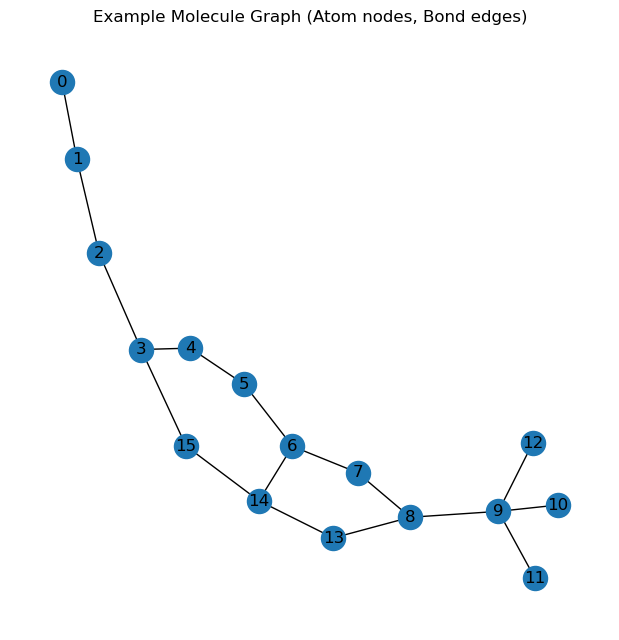

In [2]:
from torch_geometric.transforms import BaseTransform

# Custom transform to replace NaN labels with -1 for easier masking
class ReplaceNanLabelsTransform(BaseTransform):
    def __call__(self, data):
        mask_nan = torch.isnan(data.y)  # Identify NaN entries
        data.y[mask_nan] = -1           # Set NaNs to -1
        return data

# Load the Tox21 dataset, applying our transform
dataset = MoleculeNet(root='./data', name='Tox21', transform=ReplaceNanLabelsTransform())
print(f'Total molecules in Tox21: {len(dataset)}')

# Inspect the first example of the dataset
data_example = dataset[0]
print(data_example)  # Shows x, edge_index, edge_attr, y, etc.

# Visualize the molecular graph structure
G = to_networkx(data_example, to_undirected=True)
plt.figure(figsize=(6, 6))
nx.draw(G, with_labels=True, node_size=300)
plt.title('Example Molecule Graph (Atom nodes, Bond edges)')
plt.show()


**Interpreting the `Data` Object for One Molecule**

- **`x=[16, 9]`**
  The node feature matrix has **16 nodes** (atoms) and **9 features** per node (e.g. atom type one‑hots, aromaticity, etc.).

- **`edge_index=[2, 34]`**
  The COO index tensor for graph connectivity has shape 2×34, representing **34 directed edges** (i → j pairs). In an undirected molecule each bond appears twice.

- **`edge_attr=[34, 3]`**
  Each of the 34 edges carries a **3‑dimensional attribute vector** (for example: bond type one‑hot, conjugation flag, ring flag).

- **`smiles='CCOc1ccc2nc(S(N)(=O)=O)sc2c1'`**
  The **SMILES string** uniquely encoding the molecule’s structure.

- **`y=[1, 12]`**
  The label tensor has shape 12 for the 12 Tox21 tasks. A value of **1** means “active/toxic,” **0** means “inactive,” and **-1** (after our transform) denotes a missing label.

### 2.1 Train/Test Split

Split the dataset into training and test sets. We will use the first 5000 graphs for training and the rest for testing.

In [3]:
# Simple split: first 5000 for training, remainder for testing
train_dataset = dataset[:5000]
test_dataset = dataset[5000:]

# Create DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Train set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")


Train set size: 5000
Test set size: 2823


## 3. Define the GAT Model

We create a simple 2-layer GAT. We apply ELU activations (Exponential Linear Unit, a smooth version of ReLU) and global mean pooling for graph-level embedding.

In [4]:
class SimpleGAT(nn.Module):
    def __init__(self, in_channels, hidden_dim, num_classes, heads=4):
        super().__init__()
        # First graph attention layer
        self.conv1 = GATConv(in_channels, hidden_dim, heads=heads, dropout=0.1)
        # Second layer: aggregate with attention (concat=True keeps dimension)
        self.conv2 = GATConv(hidden_dim * heads, hidden_dim, heads=1, concat=True, dropout=0.1)
        # Final linear layer for multi-task classification
        self.classifier = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x, edge_index, batch):
        # x: node feature matrix, edge_index: graph connectivity, batch: batch indices
        x = self.conv1(x, edge_index)  # Apply first GATConv
        x = F.elu(x)                   # Non-linear activation
        x = self.conv2(x, edge_index)  # Second GATConv
        x = F.elu(x)                   # Activation
        x = global_mean_pool(x, batch) # Aggregate node embeddings per graph
        return self.classifier(x)      # Final prediction logits

# Instantiate the model
model = SimpleGAT(
    in_channels=dataset.num_node_features,
    hidden_dim=64,
    num_classes=12
).to(device)
print(model)  # Display model architecture


SimpleGAT(
  (conv1): GATConv(9, 64, heads=4)
  (conv2): GATConv(256, 64, heads=1)
  (classifier): Linear(in_features=64, out_features=12, bias=True)
)


## 4. Training Loop

We train using `BCEWithLogitsLoss` (a `PyTorch' loss function that combines a `Sigmoid' activation with the binary `Cross‑Entropy' loss), masking out missing labels (-1). The loss is averaged over valid labels.

Epoch 01, Loss: 0.2137
Epoch 02, Loss: 0.2108
Epoch 03, Loss: 0.2133
Epoch 04, Loss: 0.2123
Epoch 05, Loss: 0.2093
Epoch 06, Loss: 0.2105
Epoch 07, Loss: 0.2103
Epoch 08, Loss: 0.2105
Epoch 09, Loss: 0.2110
Epoch 10, Loss: 0.2102
Epoch 11, Loss: 0.2108
Epoch 12, Loss: 0.2097
Epoch 13, Loss: 0.2093
Epoch 14, Loss: 0.2072
Epoch 15, Loss: 0.2072
Epoch 16, Loss: 0.2082
Epoch 17, Loss: 0.2113
Epoch 18, Loss: 0.2107
Epoch 19, Loss: 0.2091
Epoch 20, Loss: 0.2086
Epoch 21, Loss: 0.2067
Epoch 22, Loss: 0.2081
Epoch 23, Loss: 0.2073
Epoch 24, Loss: 0.2082
Epoch 25, Loss: 0.2078
Epoch 26, Loss: 0.2084
Epoch 27, Loss: 0.2067
Epoch 28, Loss: 0.2065
Epoch 29, Loss: 0.2068
Epoch 30, Loss: 0.2049
Epoch 31, Loss: 0.2056
Epoch 32, Loss: 0.2039
Epoch 33, Loss: 0.2052
Epoch 34, Loss: 0.2057
Epoch 35, Loss: 0.2048
Epoch 36, Loss: 0.2065
Epoch 37, Loss: 0.2046
Epoch 38, Loss: 0.2038
Epoch 39, Loss: 0.2054
Epoch 40, Loss: 0.2048
Epoch 41, Loss: 0.2042
Epoch 42, Loss: 0.2031
Epoch 43, Loss: 0.2048
Epoch 44, L

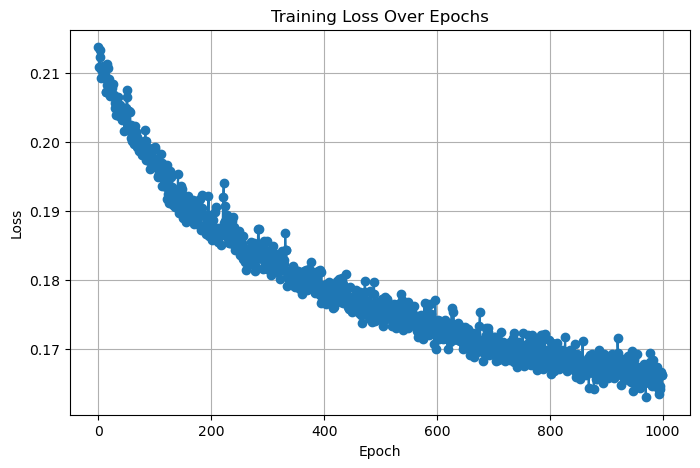

In [9]:
# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def train_epoch(loader):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        data.x = data.x.float()  # Ensure node features are float tensors

        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)  # Forward pass

        mask = (data.y != -1)  # Mask of valid labels
        if mask.sum() == 0:
            continue  # Skip if no valid labels

        # Compute binary cross-entropy for each task, sum then normalize
        loss = F.binary_cross_entropy_with_logits(
            out, data.y.float(), weight=mask.float(), reduction='sum'
        )
        loss = loss / mask.sum()  # Average loss per valid label

        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        total_loss += loss.item()
    return total_loss / len(loader)

# Run training for 50 epochs
losses = []
for epoch in range(1, 1001):
    loss = train_epoch(train_loader)
    losses.append(loss)
    print(f'Epoch {epoch:02d}, Loss: {loss:.4f}')

# Plot training loss curve
plt.figure(figsize=(8,5))
plt.plot(losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()


## 5. Evaluation

Compute ROC-AUC for each task, ignoring missing labels, and report the average.

In [10]:
def evaluate(loader):
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            data.x = data.x.float()
            out = model(data.x, data.edge_index, data.batch)
            all_preds.append(torch.sigmoid(out).cpu())  # Convert logits to probabilities
            all_targets.append(data.y.cpu())

    preds = torch.cat(all_preds, dim=0)
    targets = torch.cat(all_targets, dim=0)
    mask = (targets != -1)

    aucs = []
    for task in range(preds.size(1)):
        valid = mask[:, task]
        if valid.sum() > 0 and len(torch.unique(targets[valid, task])) > 1:
            auc = roc_auc_score(targets[valid, task], preds[valid, task])
            aucs.append(auc)
    return float(np.mean(aucs)) if aucs else 0.0

test_auc = evaluate(test_loader)
print(f'Test ROC-AUC: {test_auc:.4f}')


Test ROC-AUC: 0.7835


## 6. Visualizing ROC Curves for Individual Tasks

Plot ROC curves for one or more tasks to analyze per-task performance.

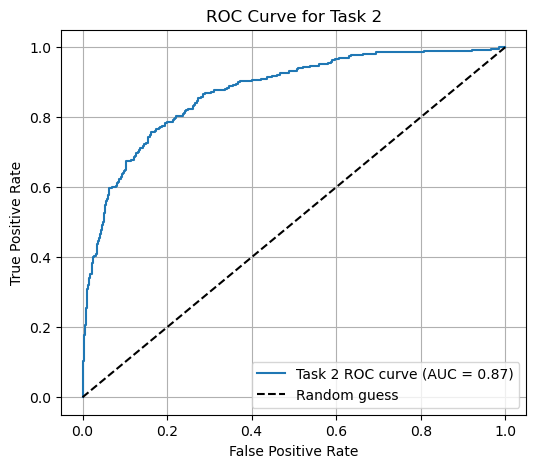

In [11]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_scores, task_index):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'Task {task_index} ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
    plt.title(f'ROC Curve for Task {task_index}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

def visualize_task_roc(model, loader, task_index=0):
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x.float(), data.edge_index, data.batch)
            all_preds.append(torch.sigmoid(out).cpu())
            all_targets.append(data.y.cpu())
    preds = torch.cat(all_preds, dim=0)
    targets = torch.cat(all_targets, dim=0)
    mask = (targets != -1)
    valid = mask[:, task_index]
    if valid.sum() > 0 and len(torch.unique(targets[valid, task_index])) > 1:
        y_true = targets[valid, task_index].numpy()
        y_scores = preds[valid, task_index].numpy()
        plot_roc_curve(y_true, y_scores, task_index)
    else:
        print(f"No valid labels for task {task_index}")

# Example usage:
visualize_task_roc(model, test_loader, task_index=2)

## 7. Visualizing Graph Embeddings with t-SNE

Extract graph-level embeddings from the last hidden layer and reduce to 2D via t-SNE.

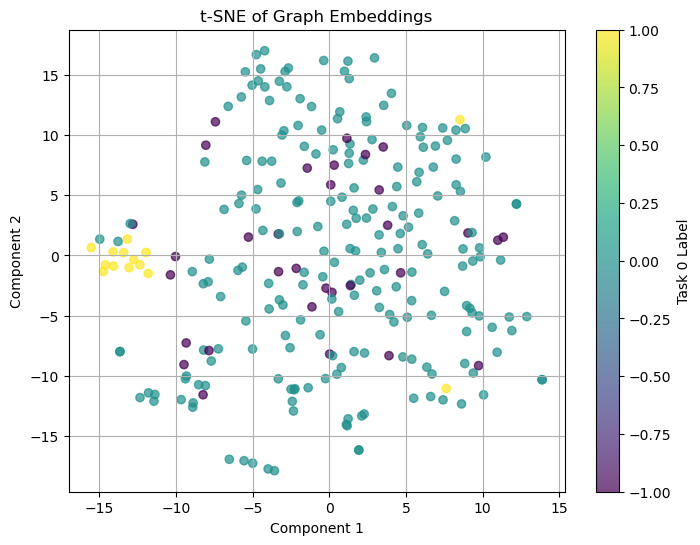

In [13]:
from sklearn.manifold import TSNE

def visualize_embeddings(model, loader, task_index=0, num_samples=200):
    model.eval()
    embeddings, labels = [], []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            x = model.conv1(data.x.float(), data.edge_index)
            x = F.elu(x)
            x = model.conv2(x, data.edge_index)
            x = F.elu(x)
            emb = global_mean_pool(x, data.batch)
            embeddings.append(emb.cpu())
            labels.append(data.y.cpu())
            if len(embeddings)*data.num_graphs >= num_samples:
                break
    embeddings = torch.cat(embeddings, dim=0)
    labels = torch.cat(labels, dim=0)
    # t-SNE projection
    tsne = TSNE(n_components=2)
    embeddings_2d = tsne.fit_transform(embeddings.numpy())
    # Plot
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                          c=labels[:, task_index].numpy(), cmap='viridis', alpha=0.7)
    plt.title("t-SNE of Graph Embeddings")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.colorbar(scatter, label=f"Task {task_index} Label")
    plt.grid(True)
    plt.show()

# Visualize embeddings for task 0
visualize_embeddings(model, test_loader, task_index=0)